# Finance Analytics

## Overview

**Business Question:**
“How have major U.S. tech stocks performed and co-moved over the past five years, and what can this tell us about risk, return, and diversification in the sector?”

**Data:** 
Stock price and volume data encapsulate investor sentiment, funamentals, and macro factors. Using daily adjusted close prices allows return-based comparison across companies and over time.

## Data Collection & Description
Data will be collected via the yahoo finance library. This data is accurate, up to date, and with no missing values. To evaluate performance, we will be pulling the daily high, low, open, close, and volume of each stock as our core metrics and diving deeper.

### Setup

In [44]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

plt.style.use("seaborn-v0_8")
sns.set_palette("muted")

print('Setup Complete')

Setup Complete


### Data Collection & Description

Pull data from all tickers into one table with columns `date, close, high, low, open, volume, ticker`. This formatting gives us all the raw data and allows for easier aggregation of metrics in the future.

In [45]:
tickers = ['NVDA', 'PLTR', 'GOOGL'] # Nvidia, Palantir, Google
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

all_data = []
for ticker in tickers:
    table = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
    
    table = table.reset_index()
    
    table.columns = ['date', 'close', 'high', 'low', 'open', 'volume']
    table['ticker'] = ticker
    
    all_data.append(table)

df = pd.concat(all_data, ignore_index=True)
df = df.sort_values(['ticker', 'date'])
df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,date,close,high,low,open,volume,ticker
2508,2020-11-02,80.659683,82.344065,80.159130,80.620949,44228000,GOOGL
2509,2020-11-03,81.719368,82.381799,80.053361,80.979476,31432000,GOOGL
2510,2020-11-04,86.694572,87.895291,84.566746,84.694860,71342000,GOOGL
2511,2020-11-05,87.521362,88.977324,86.455214,87.916139,39758000,GOOGL
2512,2020-11-06,87.383812,87.819308,86.239202,86.967183,28622000,GOOGL
...,...,...,...,...,...,...,...
2503,2025-10-23,180.479996,181.559998,175.009995,175.445007,35812300,PLTR
2504,2025-10-24,184.630005,186.169998,182.850006,182.880005,34813500,PLTR
2505,2025-10-27,189.179993,192.830002,187.520004,188.970001,47153100,PLTR
2506,2025-10-28,189.600006,191.779999,186.779999,189.479996,38201000,PLTR


Great, we were able to ingest our data without any errors, and it looks like it's in the format that we want. We want to make sure our data is clean and tidy, ensuring no duplicates, nulls, or other kinds of invalid values. Let's do some sanity checks like seeing if there are any rows with an incorrect high or low, or if any price is nonpositive.

In [46]:
print(df.info())
print('------------------------------------------------------------------------------')
print(f"Number of duplicate rows: {df.duplicated(subset=['date', 'ticker']).sum()}")
print('------------------------------------------------------------------------------')
print('Number of Nulls')
print (df.isnull().sum())
print('------------------------------------------------------------------------------')
# High must be >= Open, Close, and Low
invalid_high = df[df['high'] < df[['open', 'close', 'low']].max(axis=1)]

# Low must be <= Open, Close, and High
invalid_low = df[df['low'] > df[['open', 'close', 'high']].min(axis=1)]

print(f"Rows with impossible 'High' prices: {len(invalid_high)}")
print(f"Rows with impossible 'Low' prices: {len(invalid_low)}")

# Check if any price is non-positive
non_positive_prices = df[
    (df['open'] <= 0) | (df['high'] <= 0) | 
    (df['low'] <= 0) | (df['close'] <= 0)
]
# Check if volume is negative (zero is checked in step 4)
negative_volume = df[df['volume'] < 0]

print(f"Rows with non-positive prices: {len(non_positive_prices)}")
print(f"Rows with negative volume: {len(negative_volume)}")

<class 'pandas.core.frame.DataFrame'>
Index: 3762 entries, 2508 to 2507
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3762 non-null   datetime64[ns]
 1   close   3762 non-null   float64       
 2   high    3762 non-null   float64       
 3   low     3762 non-null   float64       
 4   open    3762 non-null   float64       
 5   volume  3762 non-null   int64         
 6   ticker  3762 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 235.1+ KB
None
------------------------------------------------------------------------------
Number of duplicate rows: 0
------------------------------------------------------------------------------
Number of Nulls
date      0
close     0
high      0
low       0
open      0
volume    0
ticker    0
dtype: int64
------------------------------------------------------------------------------
Rows with impossible 'High' prices

Everything looks good, we're good to continue. We'll be paying most attention to Close (adjusted) price and volume to evaluate our metrics. Let's see what we're looking at so far

Close Price Statistics by Ticker
              mean        std        min         max
ticker                                              
GOOGL   138.406983  36.187984  80.659683  274.570007
NVDA     61.325169  53.709355  11.213530  207.039993
PLTR     38.264841  44.738877   6.000000  198.809998


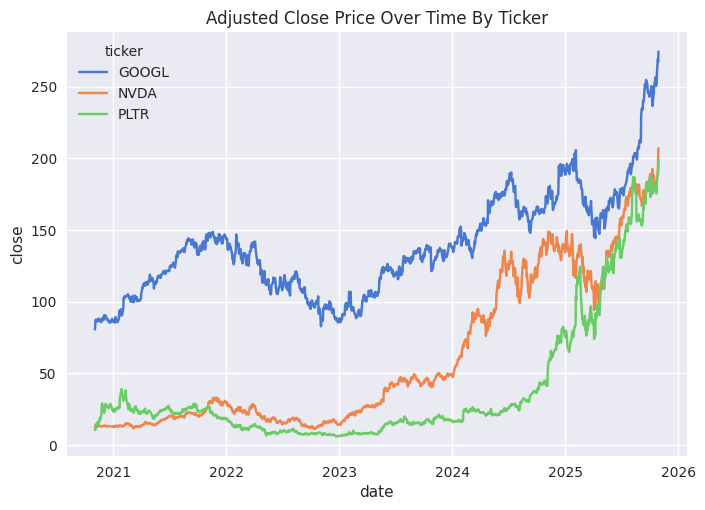

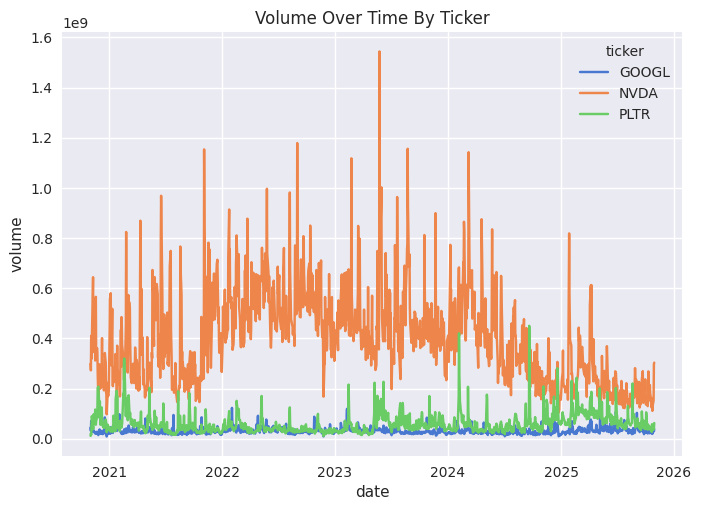

In [47]:
print('Close Price Statistics by Ticker')
print(df.groupby('ticker')['close'].describe()[['mean', 'std', 'min', 'max']])
sns.lineplot(df, x='date', y='close', hue='ticker')
plt.title('Adjusted Close Price Over Time By Ticker')
plt.show()
sns.lineplot(df, x='date', y='volume', hue='ticker')
plt.title('Volume Over Time By Ticker')
plt.show()

Just by looking at these simple figures, we can draw the following insights:
- NVDA and PLTR seem to show much higher growth and volatility (fluctuation) than GOOGL
- NVDA seems to skyrocket beginning mid-2023 which could be linked to the AI boom and consequent GPU demand
- PLTR's price sharply climbed in 2024-2025
- GOOGL shows steadier, more moderate growth with periodic dips and recoveries.
- All three show a strong upward trend in 2024-2025
- NVDA has vastly higher trading volume, peaking above 1 billion shares showing strong liquidity and investor attention
- GOOGL has relatively stable, low trading volume

## EDA

### Measuring Growth & Performance
To determine how well these stocks are doing, we'll be looking at the following metrics:
- Daily Returns: The % change in close price day to day. This measures the % of your equity that you would gain/lose for the day
- Cumulative Returns: tracks how much an investment has grown over time relative to the starting point. If cumulative return = 5, then the stock has grown 5x its value at the initial time period.

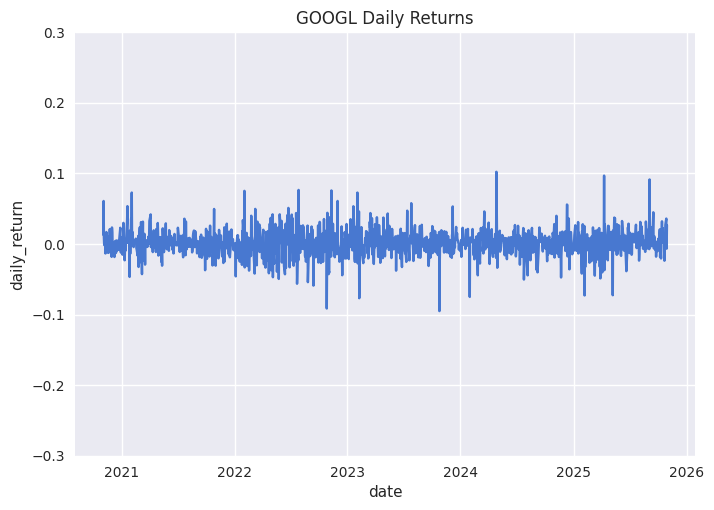

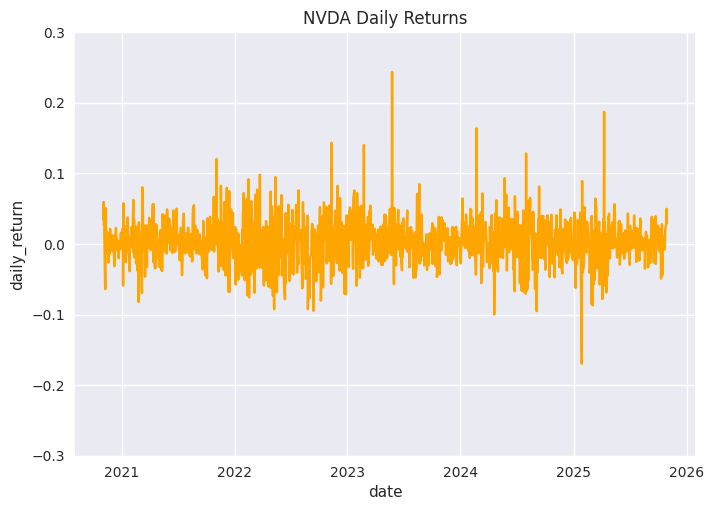

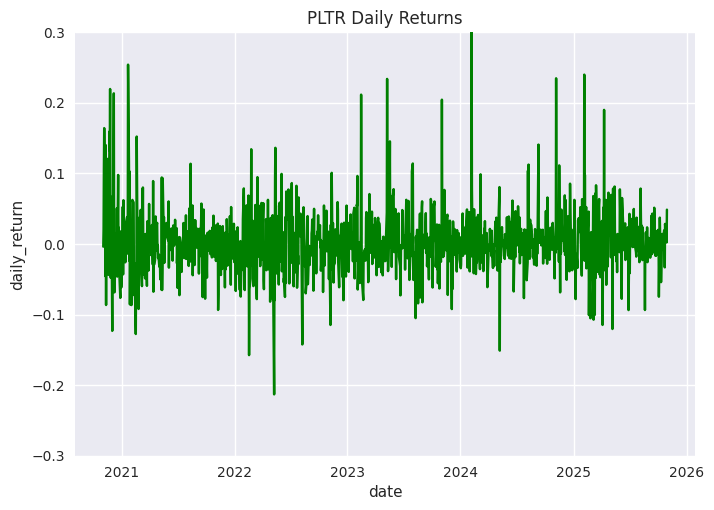

Average Daily Returns by Ticker
ticker
GOOGL    0.001167
NVDA     0.002776
PLTR     0.003332
Name: daily_return, dtype: float64


In [48]:
df["daily_return"] = df.groupby('ticker')['close'].pct_change()
df_googl = df[df['ticker'] == 'GOOGL']
df_nvda = df[df['ticker'] == 'NVDA']
df_pltr = df[df['ticker'] == 'PLTR']
avg_returns = df.groupby('ticker')['daily_return'].mean()

sns.lineplot(data=df_googl, x='date', y='daily_return',)
plt.title('GOOGL Daily Returns')
plt.ylim(-.3, .3)
plt.show()
sns.lineplot(data=df_nvda, x='date', y='daily_return', color='orange')
plt.title('NVDA Daily Returns')
plt.ylim(-.3, .3)
plt.show()
sns.lineplot(data=df_pltr, x='date', y='daily_return', color='green')
plt.title('PLTR Daily Returns')
plt.ylim(-.3, .3)
plt.show()

print('Average Daily Returns by Ticker')
print(avg_returns)

To no surprise, PLTR leads with the highest average return, with NVDA and GOOGL following in that order. However, telling by these visuals, PLTR seems to have the widest spread while GOOGL seems to be the most stable of the 3. Let's take on another perspective by looking at cumulative returns to see how much these equities have compounded the last 5 years.

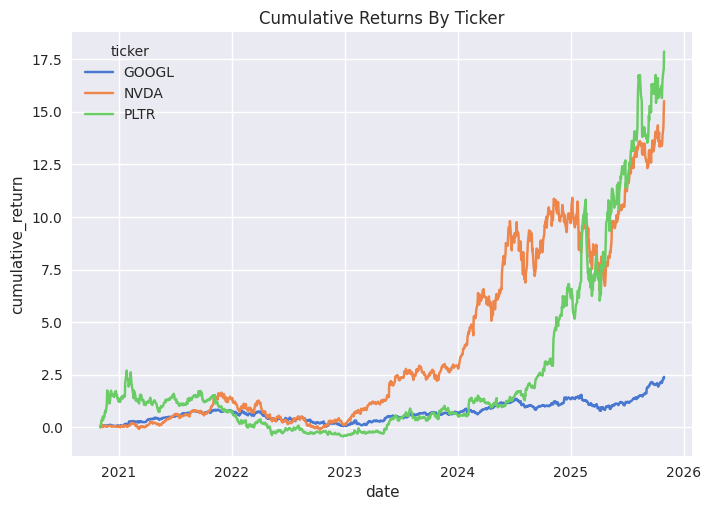

Cumulative Returns at End Date
  ticker  final_cumulative_return
0  GOOGL                 2.404055
1   NVDA                15.507125
2   PLTR                17.862429


In [49]:
df["cumulative_return"] = (1 + df["daily_return"]).groupby(df["ticker"]).cumprod() - 1
sns.lineplot(data=df, x='date', y='cumulative_return', hue='ticker')
plt.title('Cumulative Returns By Ticker')
plt.show()
print('Cumulative Returns at End Date')
final_cum_returns = (
    df.groupby("ticker")["cumulative_return"]
      .last()
      .reset_index()
      .rename(columns={"cumulative_return": "final_cumulative_return"})
)
print(final_cum_returns)

Here are some of the insights we can draw from looking at these cumulative returns:
- In 5 Years, the value of GOOGL stock has grown 2.4x, NVDA 15.5x, and PLTR 17.9X
- We see the same trend, where GOOGL grows slowly and steadily, while PLTR and NVDA have experienced rapid growth especially in the past 2-3 years, likely as a result of AI and analytics surges.
- NVDA and PLTR appear to swing a lot more with sharp peaks and dips, indicating volatility. 
- We see similar movement across the 3, indicating tech sector correlation

We're encountering the concept of risk/volatility, which is an incredibly important feature that will inform any decision made regarding these equities. In our next step, we will quantify risk to give a better overall evaluation of performance.

### Volatility

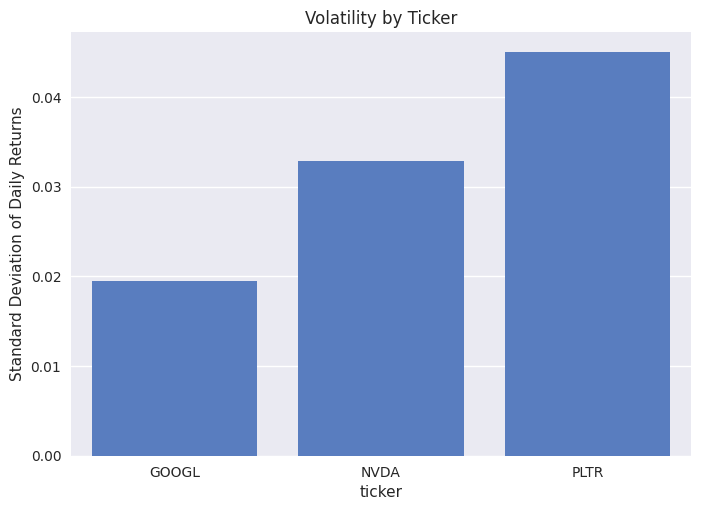

In [54]:
volatility = df.groupby("ticker")["daily_return"].std()
sns.barplot(x=volatility.index, y=volatility.values)
plt.title("Volatility by Ticker")
plt.ylabel("Standard Deviation of Daily Returns")
plt.show()

This tells us that GOOGL's returns fluctuate by around 2% every day, while NVDA fluctuates by 3.2% and PLTR by 4.5%. This tells us that GOOGL reflects a mature, large-cap company with stable cash flows and broader investor confidence, whereas PLTR reacts strongly to earnings, hype, and sentiment shifts.

Volatility isn't always a bad thing, sometimes the higher the risk, the higher reward. We want to see if these equities are worth the risk, their Sharpe Ratio in other words (the ratio of average daily return to volatility)

In [51]:
df["rolling_volatility_30d"] = (
    df.groupby("ticker")["daily_return"]
      .rolling(window=30)
      .std()
      .reset_index(level=0, drop=True)
)

df["ma_50"] = (
    df.groupby("ticker")["close"]
      .rolling(window=50)
      .mean()
      .reset_index(level=0, drop=True)
)

df["ma_200"] = (
    df.groupby("ticker")["close"]
      .rolling(window=200)
      .mean()
      .reset_index(level=0, drop=True)
)

summary = (
    df.groupby("ticker")
      .agg(
          avg_daily_return = ("daily_return", "mean"),
          volatility = ("daily_return", "std"),
          cumulative_return = ("cumulative_return", "last"),
          sharpe_ratio = ("daily_return", lambda x: np.mean(x) / np.std(x)),
          max_drawdown = ("cumulative_return", lambda x: (x.cummax() - x).max())
      )
      .reset_index()
)
print(df.tail())
print('------------------------------------------------------------------------------------------')
print(summary)

           date       close        high         low        open    volume  \
2503 2025-10-23  180.479996  181.559998  175.009995  175.445007  35812300   
2504 2025-10-24  184.630005  186.169998  182.850006  182.880005  34813500   
2505 2025-10-27  189.179993  192.830002  187.520004  188.970001  47153100   
2506 2025-10-28  189.600006  191.779999  186.779999  189.479996  38201000   
2507 2025-10-29  198.809998  199.850006  190.490005  191.080002  62905456   

     ticker  daily_return  cumulative_return  rolling_volatility_30d  \
2503   PLTR      0.028435          16.123339                0.026190   
2504   PLTR      0.022994          16.517078                0.025390   
2505   PLTR      0.024644          16.948766                0.025686   
2506   PLTR      0.002220          16.988615                0.025629   
2507   PLTR      0.048576          17.862429                0.026711   

         ma_50     ma_200  
2503  171.6888  128.72525  
2504  171.7610  129.29845  
2505  172.0012  129.